# Modelling

In [35]:
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

In [36]:
import pandas as pd
df = pd.read_csv('../data/wine_data.csv', sep=';')

In [37]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [38]:
X, y = df.drop('quality', axis=1), df.quality

Prior to any modelling, we need to pick a way of evaluating its performance. Because the model will be used in a pricing model, it is very important that the prediction is as close as possible to reality. We don't mind if the predictions are above or below in quality predictions: only how accurate they are. I've decided the the Mean Absolute Error and Root-Mean Square Error are the best measures of this.

Naturally, with these metrics decided upon, will build a regression model over a classification model since it better fits in with the evaluation metrics that we've set. I'll also capture $R^2$ score as it is a handy measure for regression models.

We will compare our model's performance against the naive model of the mode of the population.

In [43]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold

def root_mean_squared_error(*args, **kwargs):
    return mean_squared_error(*args, **kwargs)**0.5

In [44]:
results = []
kf = KFold(n_splits=10, shuffle=True)
for train_index, test_index in kf.split(X, y):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    
    model = DummyRegressor()
    model = model.fit(X_train, y_train) 
    y_hat = model.predict(X_test)
    
    results_dict = {
        'mae': mean_absolute_error(y_test, y_hat),
        'rmse': root_mean_squared_error(y_test, y_hat),
        'r2': r2_score(y_test, y_hat)
    }
    results.append(results_dict)
print("BASELINE AVERAGE MAE:", sum([fold['mae'] for fold in results]) / len(results))
print("BASELINE AVERAGE RMSE:", sum([fold['rmse'] for fold in results]) / len(results))
print("BASELINE AVERAGE R2:", sum([fold['r2'] for fold in results]) / len(results))

BASELINE AVERAGE MAE: 0.6708709571278019
BASELINE AVERAGE RMSE: 0.88503232226851
BASELINE AVERAGE R2: -0.002309394007154886


## Model Selection 

### Model 1: XGBoost without Feature Engineering

The first improvement to make would be to train an XGBoost model without adding any feature engineering.

In [67]:
import xgboost
N_SPLITS = 10

results = []
kf = KFold(n_splits=N_SPLITS, shuffle=True)
with tqdm(total=N_SPLITS) as pbar:
    for train_index, test_index in kf.split(X, y):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]

        model = xgboost.XGBRegressor(objective ='reg:squarederror')
        model = model.fit(X_train, y_train) 
        y_hat = model.predict(X_test)

        results_dict = {
            'mae': mean_absolute_error(y_test, y_hat),
            'rmse': root_mean_squared_error(y_test, y_hat),
            'r2': r2_score(y_test, y_hat),
        }
        results.append(results_dict)
        pbar.update(1)
print("XGB AVERAGE MAE:", sum([fold['mae'] for fold in results]) / len(results))
print("XGB AVERAGE RMSE:", sum([fold['rmse'] for fold in results]) / len(results))
print("XGB AVERAGE R2:", sum([fold['r2'] for fold in results]) / len(results))

100%|██████████| 10/10 [00:03<00:00,  2.63it/s]

XGB AVERAGE MAE: 0.537735741560549
XGB AVERAGE RMSE: 0.6863898708352414
XGB AVERAGE R2: 0.39671883905430605


Already we have an improvement without any hyperparameter tuning! That's a promising sign. It looks as if we are getting a weak predictor of the quality of the wine. On average, our predictions are approximately half a point away from reality.

Let's look at the distributions of the real and test data on the last fold to get an understanding of this behaviour.

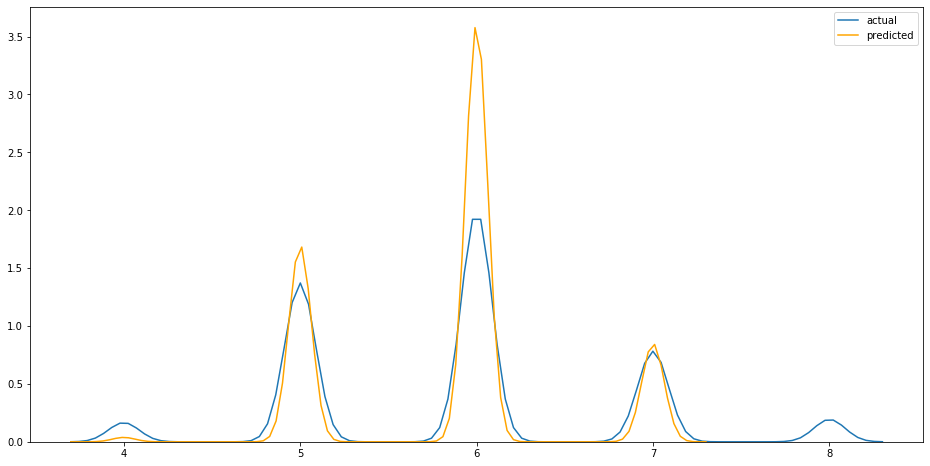

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
f, ax = plt.subplots(figsize=(16, 8))

actual = sns.kdeplot(y_test, label='actual', ax=ax, bw=0.1)
predicted = sns.kdeplot([round(x) for x in y_hat], label='predicted', ax=ax, color='orange', bw=0.1)

We can tell that the model doesn't like predicting values at the extremes. This is likely a result of a class inbalance that we saw in the EDA.

## Feature Engineering

With our lessons learnt from the EDA we can engineer some features and monitor the improvement it makes in model recall.